In [1]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Merge
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk

Using TensorFlow backend.


In [2]:
token = 'Flickr8k.token.txt'

In [3]:
captions = open(token, 'r').read().strip().split('\n')

## Creating a dictionary containing all the captions of the images

In [4]:
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [5]:
d['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [6]:
images = 'Flicker8k_Dataset/'

In [7]:
# Contains all the images
img = glob.glob(images+'*.jpg')

In [8]:
img[:5]

['Flicker8k_Dataset/3134644844_493eec6cdc.jpg',
 'Flicker8k_Dataset/2860872588_f2c7b30e1a.jpg',
 'Flicker8k_Dataset/1454678644_7e5a371301.jpg',
 'Flicker8k_Dataset/2760371526_63f3d01760.jpg',
 'Flicker8k_Dataset/3254645823_a7c072481c.jpg']

In [9]:
train_images_file = 'Flickr_8k.trainImages.txt'

In [10]:
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

In [11]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

In [12]:
# Getting the training images from all the images
train_img = split_data(train_images)
len(train_img)

6000

In [13]:
val_images_file = 'Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

In [14]:
# Getting the validation images from all the images
val_img = split_data(val_images)
len(val_img)

1000

In [15]:
test_images_file = 'Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

In [16]:
# Getting the testing images from all the images
test_img = split_data(test_images)
len(test_img)

1000

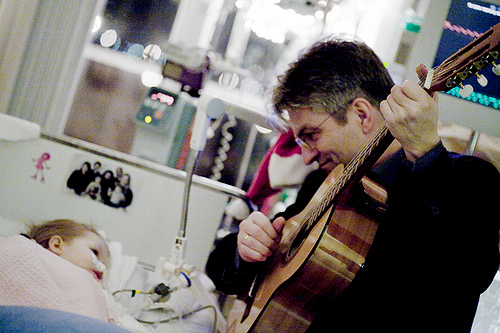

In [17]:
Image.open(train_img[0])

In [18]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [19]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


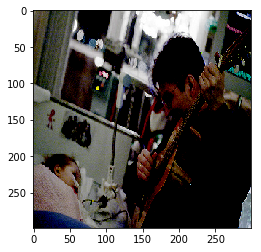

In [20]:
plt.imshow(np.squeeze(preprocess(train_img[0])))

In [21]:
model = InceptionV3(weights='imagenet')

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [22]:
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [23]:
tryi = model_new.predict(preprocess(train_img[0]))

In [24]:
tryi.shape

(1, 2048)

In [25]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [26]:
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)

100%|██████████| 6000/6000 [17:24<00:00,  6.43it/s]


In [27]:
with open("encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle) 

In [28]:
encoding_train = pickle.load(open('encoded_images_inceptionV3.p', 'rb'))

In [30]:
encoding_train['3556792157_d09d42bef7.jpg'].shape

(2048,)

In [31]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)

100%|██████████| 1000/1000 [02:53<00:00,  5.39it/s]


In [32]:
with open("encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle) 

In [33]:
encoding_test = pickle.load(open('encoded_images_test_inceptionV3.p', 'rb'))

In [34]:
encoding_test[test_img[0][len(images):]].shape

(2048,)

In [35]:
train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

In [36]:
len(train_d)

6000

In [37]:
train_d[images+'3556792157_d09d42bef7.jpg']

['A bunch of children sitting in chairs and standing on wooden floors .',
 'A group of children sit , stand , and kneel along a wall .',
 'A group of children sitting on folding chairs and playing .',
 'a young group of children sitting in a row against the wall .',
 'The kids talking while sitting on a row of chairs along the wall .']

In [38]:
val_d = {}
for i in val_img:
    if i[len(images):] in d:
        val_d[i] = d[i[len(images):]]

In [39]:
len(val_d)

1000

In [40]:
test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]

In [41]:
len(test_d)

1000

Calculating the unique words in the vocabulary.

In [42]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [43]:
words = [i.split() for i in caps]

In [44]:
unique = []
for i in words:
    unique.extend(i)

In [45]:
unique = list(set(unique))

In [46]:
# with open("unique.p", "wb") as pickle_d:
#     pickle.dump(unique, pickle_d) 

In [47]:
unique = pickle.load(open('unique.p', 'rb'))

In [48]:
len(unique)

8256

Mapping the unique words to indices and vice-versa

In [49]:
word2idx = {val:index for index, val in enumerate(unique)}

In [50]:
word2idx['<start>']

5553

In [51]:
idx2word = {index:val for index, val in enumerate(unique)}

In [52]:
idx2word[5553]

'<start>'

Calculating the maximum length among all the captions

In [53]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

40

In [54]:
len(unique), max_len

(8256, 40)

In [55]:
vocab_size = len(unique)

In [56]:
vocab_size

8256

Adding <start> and <end> to all the captions to indicate the starting and ending of a sentence. This will be used while we predict the caption of an image

In [57]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [58]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [59]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')

In [60]:
len(df)

30000

In [61]:
c = [i for i in df['captions']]
len(c)

30000

In [62]:
imgs = [i for i in df['image_id']]

In [63]:
a = c[-1]
a, imgs[-1]

('<start> A young man wearing a black shirt looks down . <end>',
 '518789868_8895ef8792.jpg')

In [64]:
for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 5553
A => 4228
young => 7270
man => 4779
wearing => 5041
a => 32
black => 2143
shirt => 1087
looks => 1446
down => 2383
. => 7023
<end> => 5232


In [65]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [66]:
samples_per_epoch

383454

## Generator 



In [67]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    n = np.zeros(vocab_size)
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

## The model

In [69]:
embedding_size = 300

In [70]:
image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(max_len)
    ])

In [71]:
caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [73]:
final_model = Sequential([
        Merge([image_model, caption_model], mode='concat', concat_axis=1),
        Bidirectional(LSTM(256, return_sequences=False)),
        Dense(vocab_size),
        Activation('softmax')
    ])

In [74]:
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [75]:
final_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 300)           614700                                       
____________________________________________________________________________________________________
repeatvector_1 (RepeatVector)    (None, 40, 300)       0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 40, 300)       2476800                                      
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 40, 256)       570368                                       
___________________________________________________________________________________________

In [75]:
final_model.fit_generator(data_generator(batch_size=256), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=1)

Epoch 1/1
383488/383454 [==============================] - 4388s - loss: 4.1002 - acc: 0.2993  


/home/vibertron/environments/venv/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [103]:
final_model.fit_generator(data_generator(batch_size=256), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=1)

Epoch 1/1
959s - loss: 3.3411 - acc: 0.4033


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [111]:
final_model.fit_generator(data_generator(batch_size=256), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=1)

Epoch 1/1
959s - loss: 3.3024 - acc: 0.4138


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [119]:
final_model.fit_generator(data_generator(batch_size=256), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=1)

Epoch 1/1
958s - loss: 3.2991 - acc: 0.4214


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [144]:
final_model.fit_generator(data_generator(batch_size=256), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=1)

Epoch 1/1
959s - loss: 3.2920 - acc: 0.4288


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [161]:
final_model.optimizer.lr = 1e-4
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
958s - loss: 3.2612 - acc: 0.4302


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [174]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
958s - loss: 3.2604 - acc: 0.4357


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [175]:
final_model.save_weights('time_inceptionV3_7_loss_3.2604.h5')

In [57]:
final_model.load_weights('time_inceptionV3_7_loss_3.2604.h5')

In [58]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
1017s - loss: 3.2368 - acc: 0.4399


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [69]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
993s - loss: 3.2185 - acc: 0.4458


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [78]:
final_model.save_weights('time_inceptionV3_3.21_loss.h5')

In [79]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
993s - loss: 3.2044 - acc: 0.4505


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [88]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
992s - loss: 3.1809 - acc: 0.4539


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [101]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
992s - loss: 3.1510 - acc: 0.4589


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [110]:
final_model.save_weights('time_inceptionV3_3.15_loss.h5')

In [ ]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
992s - loss: 3.1449 - acc: 0.4643


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [76]:
final_model.load_weights('weights/time_inceptionV3_1.5987_loss.h5')

## Predict function

In [78]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [94]:
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encoding_test[image[len(images):]]
            preds = final_model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

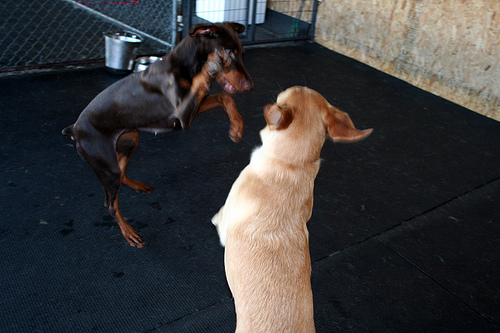

In [95]:
try_image = test_img[0]
Image.open(try_image)

In [96]:
print ('Normal Max search:', predict_captions(try_image)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))

Normal Max search: Two dogs play with a red plastic toy in the tall grass .
Beam Search, k=3: Two dogs play with a red plastic toy in the tall grass .
Beam Search, k=5: Two dogs , one with a tennis ball in his mouth , play together outside .
Beam Search, k=7: Two dogs , one with a tennis ball in his mouth , play together outside .


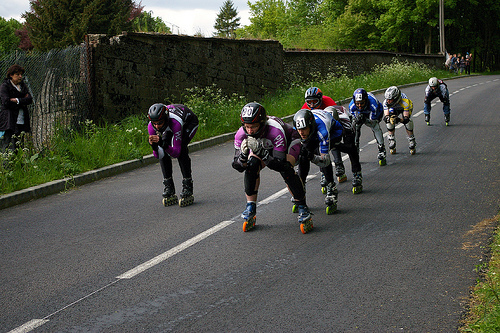

In [82]:
try_image2 = test_img[7]
Image.open(try_image2)

In [83]:
print ('Normal Max search:', predict_captions(try_image2)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image2, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image2, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image2, beam_index=7))

Normal Max search: Several people are hiking down a cement wall with an open and one the woman giving the peace sign .
Beam Search, k=3: Many people run in a race on a street .
Beam Search, k=5: Many people run in a race on a street .
Beam Search, k=7: Many people run in a race on a street .


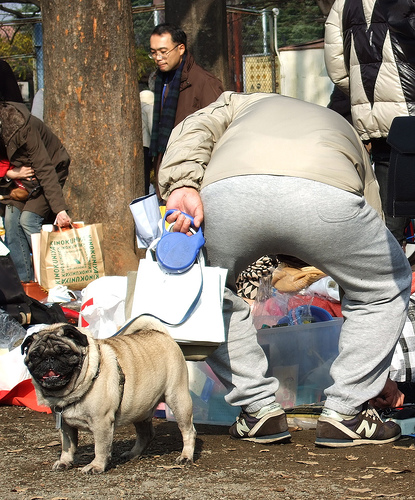

In [84]:
try_image3 = test_img[851]
Image.open(try_image3)

In [85]:
print ('Normal Max search:', predict_captions(try_image3)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image3, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image3, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image3, beam_index=7))

Normal Max search: A man wearing a white shirt is wearing a brown coat and hat .
Beam Search, k=3: A man wearing a purple hat and with head stands with a dog .
Beam Search, k=5: An elderly man is holding and looking at an object .
Beam Search, k=7: An elderly man is holding and looking at an object .


Normal Max search: A person on a bike is coming up through the mud .
Beam Search, k=3: A guy is doing a trick on a bike .
Beam Search, k=5: A mountain biker jumps a rock on a mountain .
Beam Search, k=7: A mountain biker is riding on a line back at bushes .


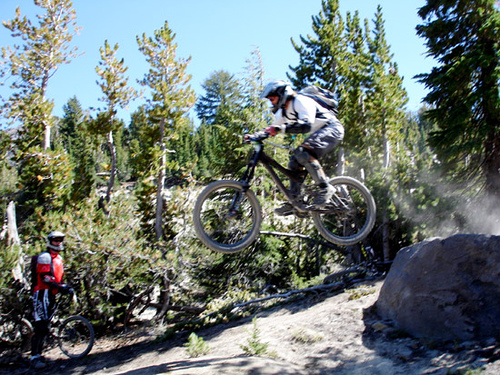

In [86]:
try_image4 = 'Flicker8k_Dataset/136552115_6dc3e7231c.jpg'
print ('Normal Max search:', predict_captions(try_image4))
print ('Beam Search, k=3:', beam_search_predictions(try_image4, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image4, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image4, beam_index=7))
Image.open(try_image4)

Normal Max search: A dog is jumping in the air to catch something .
Beam Search, k=3: A brown dog is jumping in the air .
Beam Search, k=5: A dog is jumping in the air to catch something .
Beam Search, k=7: A dog in a harness holds a stick in his mouth while standing in the grass .


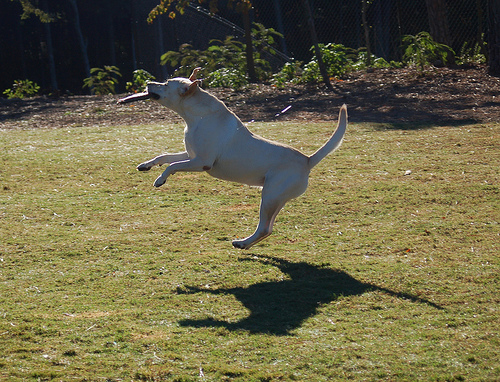

In [87]:
im = 'Flicker8k_Dataset/1674612291_7154c5ab61.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A tan dog runs through the snow .
Beam Search, k=3: A tan dog runs through the snow .
Beam Search, k=5: A tan dog runs through the snow .
Beam Search, k=7: Brown dog running through snow .


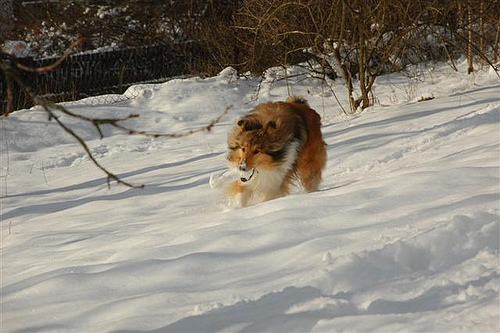

In [88]:
im = 'Flicker8k_Dataset/384577800_fc325af410.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A man is riding a surfboard
Beam Search, k=3: A man rides a wave on a surfboard .
Beam Search, k=5: A man rides a surfboard as a wave makes a splash .
Beam Search, k=7: A man rides a surfboard as a wave makes a splash .


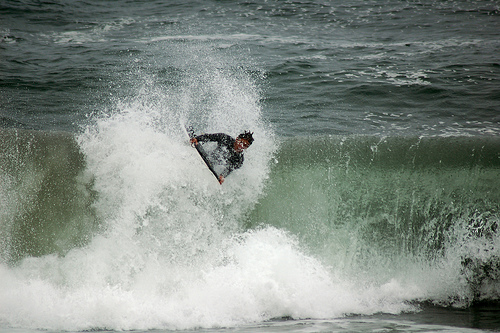

In [89]:
im = 'Flicker8k_Dataset/3631986552_944ea208fc.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A little girl in a red coat plays in snow .
Beam Search, k=3: A little kid plays in the snow in a brown jacket and red shorts on a harness .
Beam Search, k=5: Little girl in red coat going down a hill .
Beam Search, k=7: Little girl in red coat going down a hill .


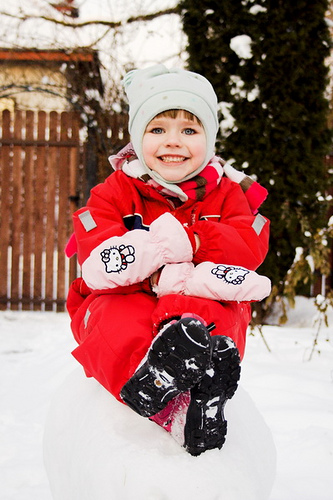

In [90]:
im = 'Flicker8k_Dataset/3320032226_63390d74a6.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A man rides a bicycle on a trail down a river .
Beam Search, k=3: A man is riding a bicycle on a trail through some trees .
Beam Search, k=5: A man rides a mountain bike down a slope in the woods .
Beam Search, k=7: A man rides a bicycle on a trail down a river .


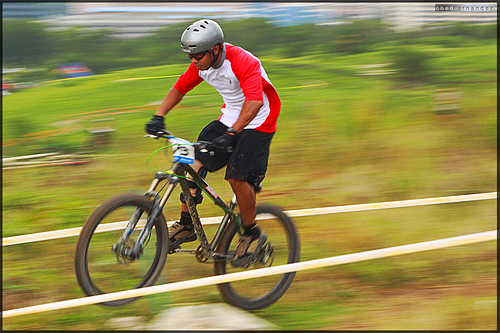

In [91]:
im = 'Flicker8k_Dataset/3316725440_9ccd9b5417.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A skateboarder in the air in front of a red slide .
Beam Search, k=3: A skateboarder in the air in front of a blue building .
Beam Search, k=5: A skateboarder in the air in front of a blue building .
Beam Search, k=7: A male skateboarder is skating in a skate park .


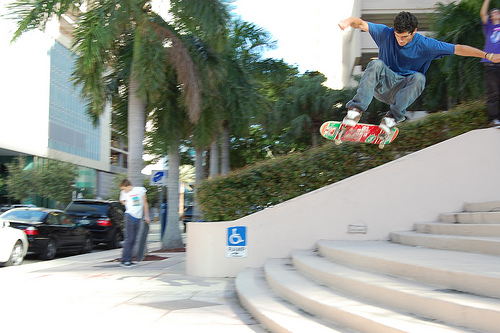

In [92]:
im = 'Flicker8k_Dataset/2306674172_dc07c7f847.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)